[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dean\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dean\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0.09450208847852394


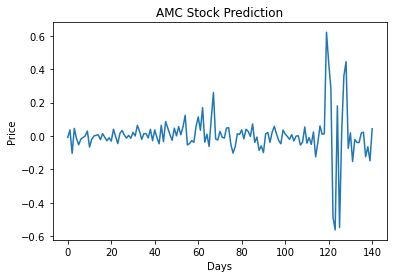

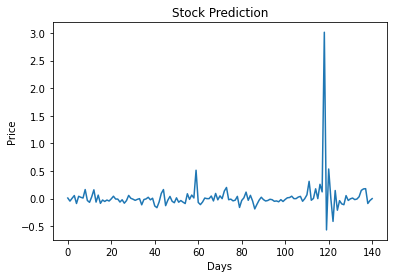

The stock will reach the highest price of: 
3.1910200000000004
after this amount of days: 
17.0
0.062295783220274834


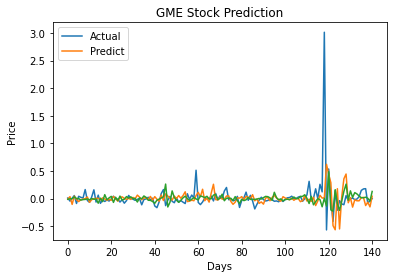

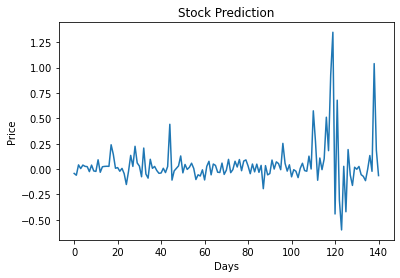

The stock will reach the highest price of: 
1.44582
after this amount of days: 
17.0
<generator object modelTweets at 0x000001F5AE9E6F48>
The sentiment score is very low which could indicate the stock prices will go down. We highly recommend you do not buy stocks soon.


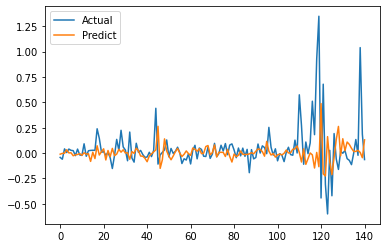

In [10]:
import datetime
from numpy import array
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
from numpy import loadtxt
from keras.models import load_model
import datetime
import warnings
import nltk 
import re
import random
from datetime import timedelta, date
from pandas import DataFrame
from nltk import *
from nltk.corpus import *
from nltk.tokenize import *
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')

amc_model = load_model('AMCModel.h5')
gme_model = load_model('GMEModel.h5')

amc_testing = pd.read_csv(r'./Data/AMC_testing_data.csv', index_col=0, parse_dates=True)
gme_testing = pd.read_csv(r'./Data/GME_testing_data.csv', index_col=0, parse_dates=True)

# Stock Prediction




def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)



def testing_data_prep(testing_set, model, name):
    n_steps = 8
    #data here taken from csv columns, have a look at the tetsing set for the format
    price_testing = testing_set['Price'].values
    price_open_testing = testing_set['Open'].values
    price_high_testing = testing_set['High'].values
    price_low_testing = testing_set['Low'].values
    price_vol_testing = testing_set['Vol.'].values
    price_change_testing = testing_set['Change %'].values

    #runs the above split function to make the datset into small arrays with 8 steps each, copy the function for prediction
    #this will need to be done to any prediction, it needs 8 steps behind to predict
    Tprice, y = split_sequence(price_testing, n_steps)
    Tprice = Tprice.reshape((Tprice.shape[0], n_steps, 1))
    
    Topen, y = split_sequence(price_open_testing, n_steps)
    Topen = Topen.reshape((Topen.shape[0], n_steps, 1))
    
    Thigh, y = split_sequence(price_high_testing, n_steps)
    Thigh = Thigh.reshape((Thigh.shape[0], n_steps, 1))
    
    Tlow, y = split_sequence(price_low_testing, n_steps)
    Tlow = Tlow.reshape((Tlow.shape[0], n_steps, 1))
    
    TVol, y = split_sequence(price_low_testing, n_steps)
    TVol = Tlow.reshape((Tlow.shape[0], n_steps, 1))
    
    Tchange, y = split_sequence(price_change_testing, n_steps)
    Tchange = Tchange.reshape((Tchange.shape[0], n_steps, 1))

    #This line takes all of the split arrays and puts them together, shapinng the data structure to fit the lstm
    Ttraining = np.concatenate((Tprice, Topen, Thigh, Tlow, Tchange), axis = 2)

    #may have to run this line once to prune the end of the data
    #this line is just for accuracy testing, it aligns the testing dataset with the first output
    price_change_testing_test = price_change_testing[8:]
    
    #predicts using the correct dataset
    predictions = model.predict(Ttraining)
    mse = mean_squared_error(price_change_testing_test, predictions)
    print(mse)
    #with the predictions you can model them or if its just one output it
    # Add title and axis names
    plt.title(name + ' Stock Prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.plot(predictions)
    plt.show()
    
    
    
    
    
    plt.title('Stock Prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.plot(price_change_testing_test)
    plt.savefig('prediction.jpg')
    plt.show()
    
    
    
    lstm_acc_df = pd.DataFrame()
    price_change_testing_test = price_change_testing_test.reshape(price_change_testing_test.shape[0],1)
    lstm_acc_df['Actual'] = price_change_testing_test[:,0]
    lstm_acc_df['Predict'] = predictions[:,0]
    lstm_acc_df.plot()   
    
    
    axes = plt.gca()
    y_min, y_max = axes.get_ylim()
    #print(y_max) # Print the maximum y value
    max_x = 'Days'[y_max.argmax()]  # Find the x value corresponding to the maximum y value
    print("The stock will reach the highest price of: ")
    print(y_max)
    print("after this amount of days: ")
    four = (ord(max_x))
    x = four/4
    print(x)
    
    
    StockDate = datetime.datetime.today() + datetime.timedelta(days=x)
    
    
    return StockDate
    
#runs the testing function, with some modifications and the correct dataset you will be able to run a similar function
StockDate = testing_data_prep(amc_testing, amc_model, "AMC")
StockDate = testing_data_prep(gme_testing, gme_model, "GME")


# sentiment analysis

#Create the stemmer object
stemmer = PorterStemmer()
#initialise training sets
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
#set the training sets into a dataframe
posTweetsdf = DataFrame(positive_tweets,columns=['text'])
negTweetsdf = DataFrame(negative_tweets,columns=['text'])

#Read the file 
data = pd.read_csv("Data/reddit_wsb.csv") 



def cleanData(data):
    #Loop through the data, creating a new dataframe with only ascii characters
    data['text'] = data['text'].apply(lambda s: "".join(char for char in s if char.isascii()))
    #Removes any words which start with @, which are replies. 
    data['text']= data['text'].str.replace('(@\w+.*?)',"")
    #Remove any left over characters 
    data = data['text'].str.replace('[^\w\s]','')
    #return the cleaned data
    return data

def removeStopwords(data):
    #Choose the english stopwords
    eng_stopwords = stopwords.words('english')
    #Set the english stopwords
    eng_stopwords = set(eng_stopwords)
    #Create a new list/series containing only words which arent in eng_stopwords
    result = data.apply(lambda words: [word for word in words if word.lower() not in eng_stopwords])
    #The stemming process is built into the remove stopwords function to cut down on individual functions. 
    #This uses the PorterStemmer, built into NLTK, to stem words. 
    result = result.apply(lambda x: [stemmer.stem(y) for y in x])
    return result

def wordCount(data):
    for words in data:
        for word in words:
            yield word

#Used for modelling the tweets and posts to the correct format so as they can be fed into the Naive Bayes classifier
def modelTweets(data):
    for words in data:
         yield dict([word, True] for word in words)
            
def toDict(word):
     return {word : True}


# droppeddata will store the new dataframe with the dropped columns

#For now, two variables exist, one with the timestamp attached and one without, timestamp will be used in future versions
dataTimestamped = data.drop(columns=['score', 'id','url','comms_num','created','body'])
data = data.drop(columns=['score', 'id','url','comms_num','created','body','timestamp'])

data.columns = ['text']

#runs the neccesary functions which will clean the data, tokenize it and remove any stopwords.
dataCleaned = cleanData(data)
dataCleaned = dataCleaned.apply(word_tokenize)
data = removeStopwords(dataCleaned)

#Cleans the positive training set
posTweetsdf = cleanData(posTweetsdf)
posTweets = posTweetsdf.apply(word_tokenize)
posTweets = removeStopwords(posTweets)

#Cleans the negative training set
negTweetsdf = cleanData(negTweetsdf)
negTweets = negTweetsdf.apply(word_tokenize)
negTweets = removeStopwords(negTweets)

data = data.tolist()
dataCount = wordCount(data)
dataFreq = FreqDist(dataCount)

negTweets = negTweets.tolist()
negWords = wordCount(negTweets)
negFreq = FreqDist(negWords)

posTweets = posTweets.tolist()
posWords = wordCount(posTweets)
posFreq = FreqDist(posWords)

posModel = modelTweets(posTweets)
negModel = modelTweets(negTweets)
testModel = modelTweets(data)

posDataset = [(tweet_dict, "Positive")
                     for tweet_dict in posModel]

negDataset = [(tweet_dict, "Negative")
                     for tweet_dict in negModel]

trainingDataset = posDataset + negDataset
random.shuffle(trainingDataset)
trainData, testData = trainingDataset[7000:], trainingDataset[:7000]
classifier = NaiveBayesClassifier.train(trainData)

Sentiments = []
for x in testModel:
    Sentiments.append(classifier.classify(x))
print(testModel)
positive = Sentiments.count('Positive')
negative = Sentiments.count('Negative')


allposts = negative + positive
avgneg = negative / allposts
avgpos = positive / allposts




if avgpos > 0.5:
    print("The sentiment score is very high. This indicates stock prices will go up. You Should buy stocks soon.")
    print("The stock price will be highest on this day ", StockDate, ". If you buy before this day and sell on the specified day, you will make money!!!")

elif avgpos < 0.5:
    print("The sentiment score is very low which could indicate the stock prices will go down. We highly recommend you do not buy stocks soon.")
